# HOMEWORK PART 3

---

## For the Lorenz equations, consider the following.
1. Train a NN to advance the solution from t to t+∆t for ρ = 10,28 and 40. Now see how well your NN
works for future state prediction for ρ = 17 and ρ = 35.
2. See if you can train your NN to identify (for ρ = 28) when a transition from one lobe to another is imminent. Determine how far in advance you can make this prediction. (NOTE: you will have to label the transitions in a test set in order to do this task)

Let's consider the Lorenz equations:

\begin{align}
x' &= \sigma (y - x) \\
y' &= rx -y - xz \\
z' &= xy -bz
\end{align}

These equations are a simplified model of convection-driven atmospheric motion.
They are very **sensitive to initial conditions** so that a small perturbation of them cause completely different trajectory.

In [4]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.utils.data as Data

#! pip install pyrenn
import pyrenn as prn

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

## Part 1: Train a NN to advance the solution from t to t+∆t for ρ = 10,28 and 40. Now see how well your NN works for future state prediction for ρ = 17 and ρ = 35.

In [2]:
def Lorenz(x, t, dummy, sigma, b, r):
    """Lorenz equations
    
    Parameters
    ----------
    t : array
        Discretization in time.
    x0 : array
        Initial conditions.
    b, p, d, r : float
        Parameters.

    Returns
    -------
    rhs : array
       Integration of the state.
    """
    
    x1, x2, x3 = x
    
    rhs = [sigma * (x2 - x1),
           r * x1 - x2 - x1 * x3,
           x1 * x2 - b * x3]
    return rhs

<IPython.core.display.Javascript object>


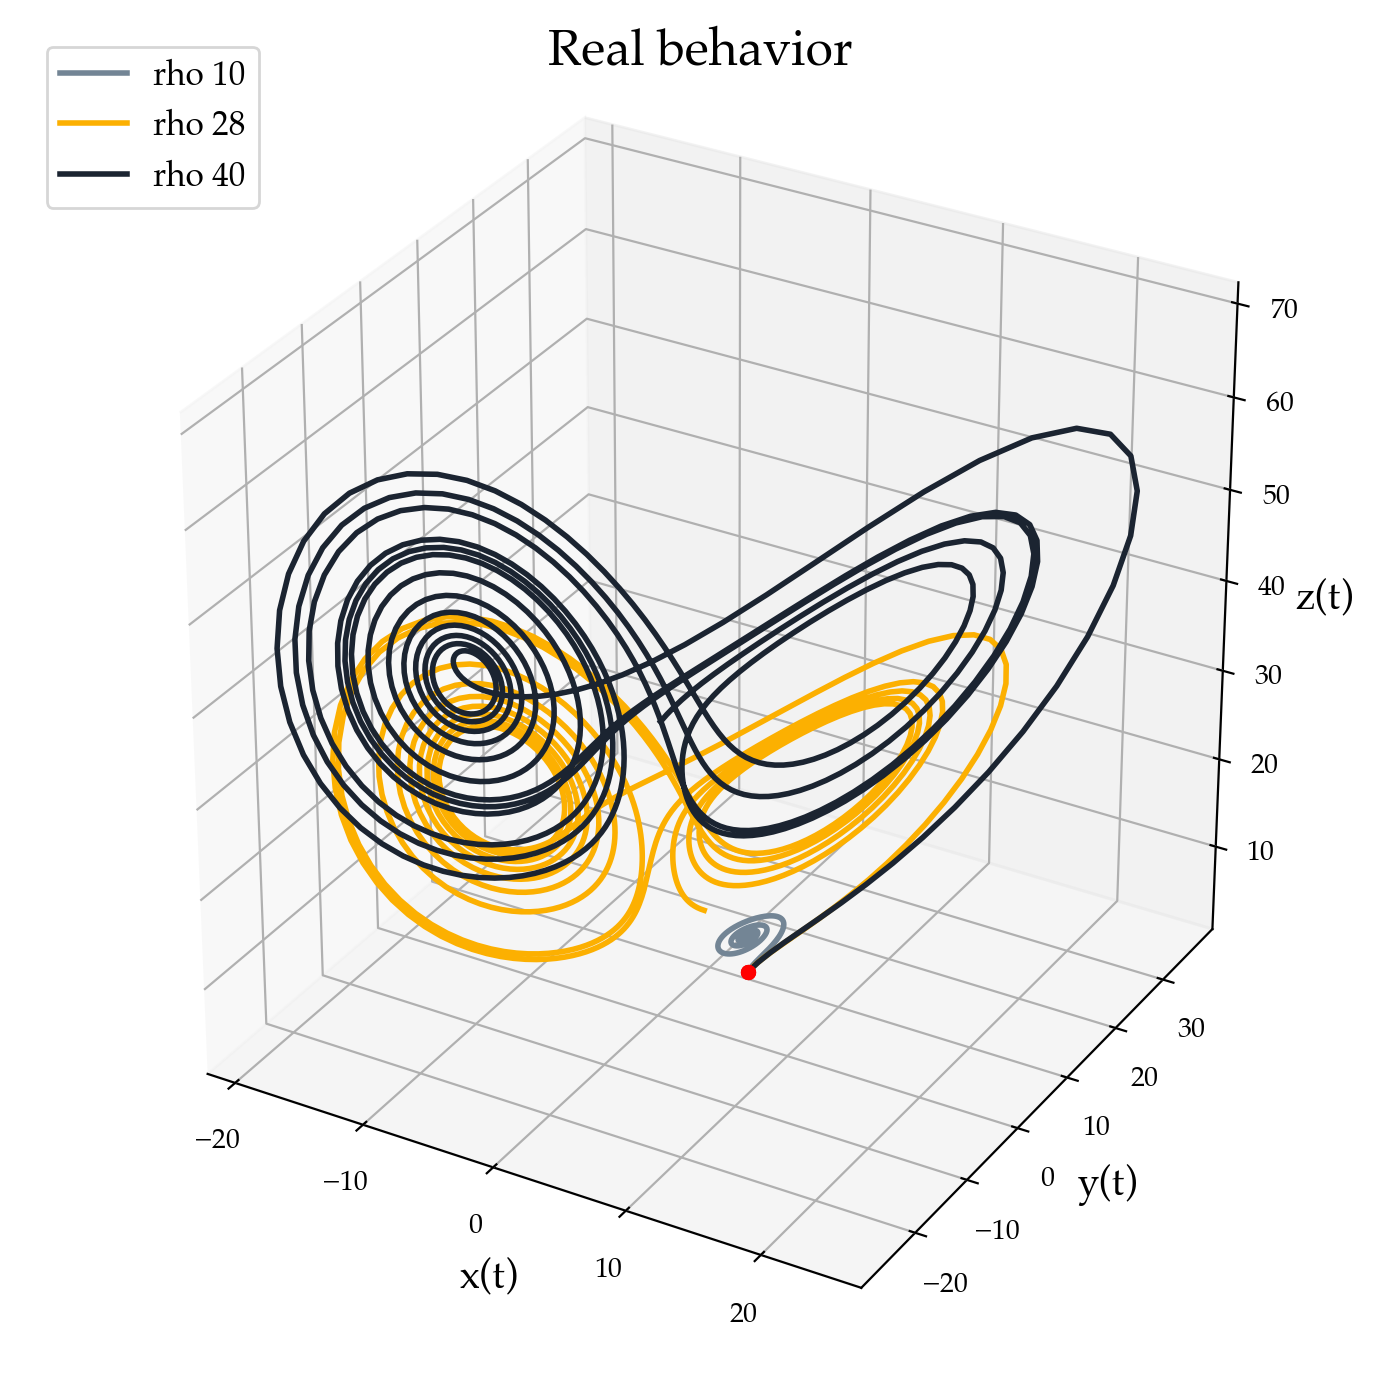

In [17]:
fig = plt.figure(figsize=(7, 7))
fig.suptitle("Real behavior", fontsize=18)

gs = gridspec.GridSpec(1, 1)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.1, hspace=0.1)
ax = plt.subplot(gs[0, 0], projection='3d')

seed = 123
dt = 0.01
final_t = 10
n = int(final_t / dt) + 1
t = np.linspace(0, final_t, n)

beta = 8/3
sigma = 10
rho = [10, 28, 40]
x0 = [5, 5, 5] # initial conditions

colors = iter(['xkcd:steel', 'xkcd:yellow orange', 'xkcd:dark'])
lgd = []

X_train, y_train = np.empty((0,4)), np.empty((0,3))
X_val, y_val = np.empty((0,4)), np.empty((0,3))
X_test, y_test = np.empty((0,4)), np.empty((0,3))

for _rho in rho:

    lor = odeint(Lorenz, x0, t, args=([], sigma, beta, _rho), mxstep=10**8) # integrate PDE
    x = np.reshape(lor[:, 0], (-1, 1))
    y = np.reshape(lor[:, 1], (-1, 1))
    z = np.reshape(lor[:, 2], (-1, 1))
    param = np.ones_like(x) * _rho
    data = np.hstack((x, y, z, param))
    X = data[:-1, :]
    y = data[1:, :-1]
    _X_train, _X_tmp, _y_train, _y_tmp = train_test_split(X, y, test_size=0.3, random_state=seed)
    _X_val, _X_test, _y_val, _y_test = train_test_split(_X_tmp, _y_tmp, test_size=0.5, random_state=seed)
    X_train = np.append(X_train, _X_train, axis=0)
    y_train = np.append(y_train, _y_train, axis=0)
    X_val = np.append(X_val, _X_val, axis=0)
    y_val = np.append(y_val, _y_val, axis=0)
    X_test = np.append(X_test, _X_test, axis=0)
    y_test = np.append(y_test, _y_test, axis=0)

    ax.scatter(data[0, 0], data[0, 1], data[0, 2], 'o', color='r')
    ax.plot(data[:, 0], data[:, 1], data[:, 2], linewidth='2', color=next(colors))
    lgd.append('rho %d' % _rho)
    
ax.set_xlabel('x(t)', fontsize = 14)
ax.set_ylabel('y(t)', fontsize = 14)
ax.set_zlabel('z(t)', fontsize = 14)
ax.grid()
ax.legend(lgd, fontsize = 12, loc='upper left')

gs.tight_layout(fig)

In [18]:
epochs = 100

Train a neural network with Levenberg–Marquardt algorithm.

In [19]:
net_LM = prn.CreateNN([4,10,10,10,3])
net_LM = prn.train_LM(X_train.T, y_train.T, net_LM,verbose=True, k_max=epochs, E_stop=1e-5)

Iteration:  0 		Error:  1985.3500430240883 	scale factor:  3.0
Iteration:  1 		Error:  122.07952514049553 	scale factor:  0.3
Iteration:  2 		Error:  26.11290481452354 	scale factor:  3.0
Iteration:  3 		Error:  20.783998741059783 	scale factor:  0.3
Iteration:  4 		Error:  5.2505137439668195 	scale factor:  0.03
Iteration:  5 		Error:  0.47147524609370817 	scale factor:  0.03
Iteration:  6 		Error:  0.3706307615883407 	scale factor:  0.03
Iteration:  7 		Error:  0.17338828108405868 	scale factor:  0.03
Iteration:  8 		Error:  0.07783334339889943 	scale factor:  0.03
Iteration:  9 		Error:  0.033372686460751325 	scale factor:  0.03
Iteration:  10 		Error:  0.018866333500616363 	scale factor:  0.03
Iteration:  11 		Error:  0.014038358012363793 	scale factor:  0.03
Iteration:  12 		Error:  0.01179193192233307 	scale factor:  0.03
Iteration:  13 		Error:  0.010363362323413536 	scale factor:  0.03
Iteration:  14 		Error:  0.00930946277417526 	scale factor:  0.03
Iteration:  15 		Error:  0.

In [20]:
class MLPNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLPNN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, H)
        self.linear4 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.linear2(h_relu).clamp(min=0)
        h_relu = self.linear3(h_relu).clamp(min=0)
        y_pred = self.linear4(h_relu)
        return y_pred

In [21]:
batch = 1 #int(X_train.shape[0] / len(rho) / 10)

train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)

Train a neural network with SGD

In [22]:
D_in, H, D_out = 4, 10, 3
epochs = 100

net_Adam = MLPNN(D_in, H, D_out)

criterion = torch.nn.MSELoss(reduction='sum') 
optimizer = torch.optim.Adam(net_Adam.parameters(), lr=1e-3)
train_loss = []
for epoch in range(epochs):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = net_Adam(batch_x)
        loss = criterion(y_pred, batch_y)
        train_loss.append(loss.item())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print("Iteration: ", epoch, " Loss: ", loss.item())

Iteration:  0  Loss:  31.76555633544922
Iteration:  10  Loss:  0.017620345577597618
Iteration:  20  Loss:  0.09006669372320175
Iteration:  30  Loss:  0.048563048243522644
Iteration:  40  Loss:  0.021239088848233223
Iteration:  50  Loss:  0.021465212106704712
Iteration:  60  Loss:  0.10891222208738327
Iteration:  70  Loss:  1.3974523544311523
Iteration:  80  Loss:  0.018587419763207436
Iteration:  90  Loss:  0.05347004532814026


<IPython.core.display.Javascript object>


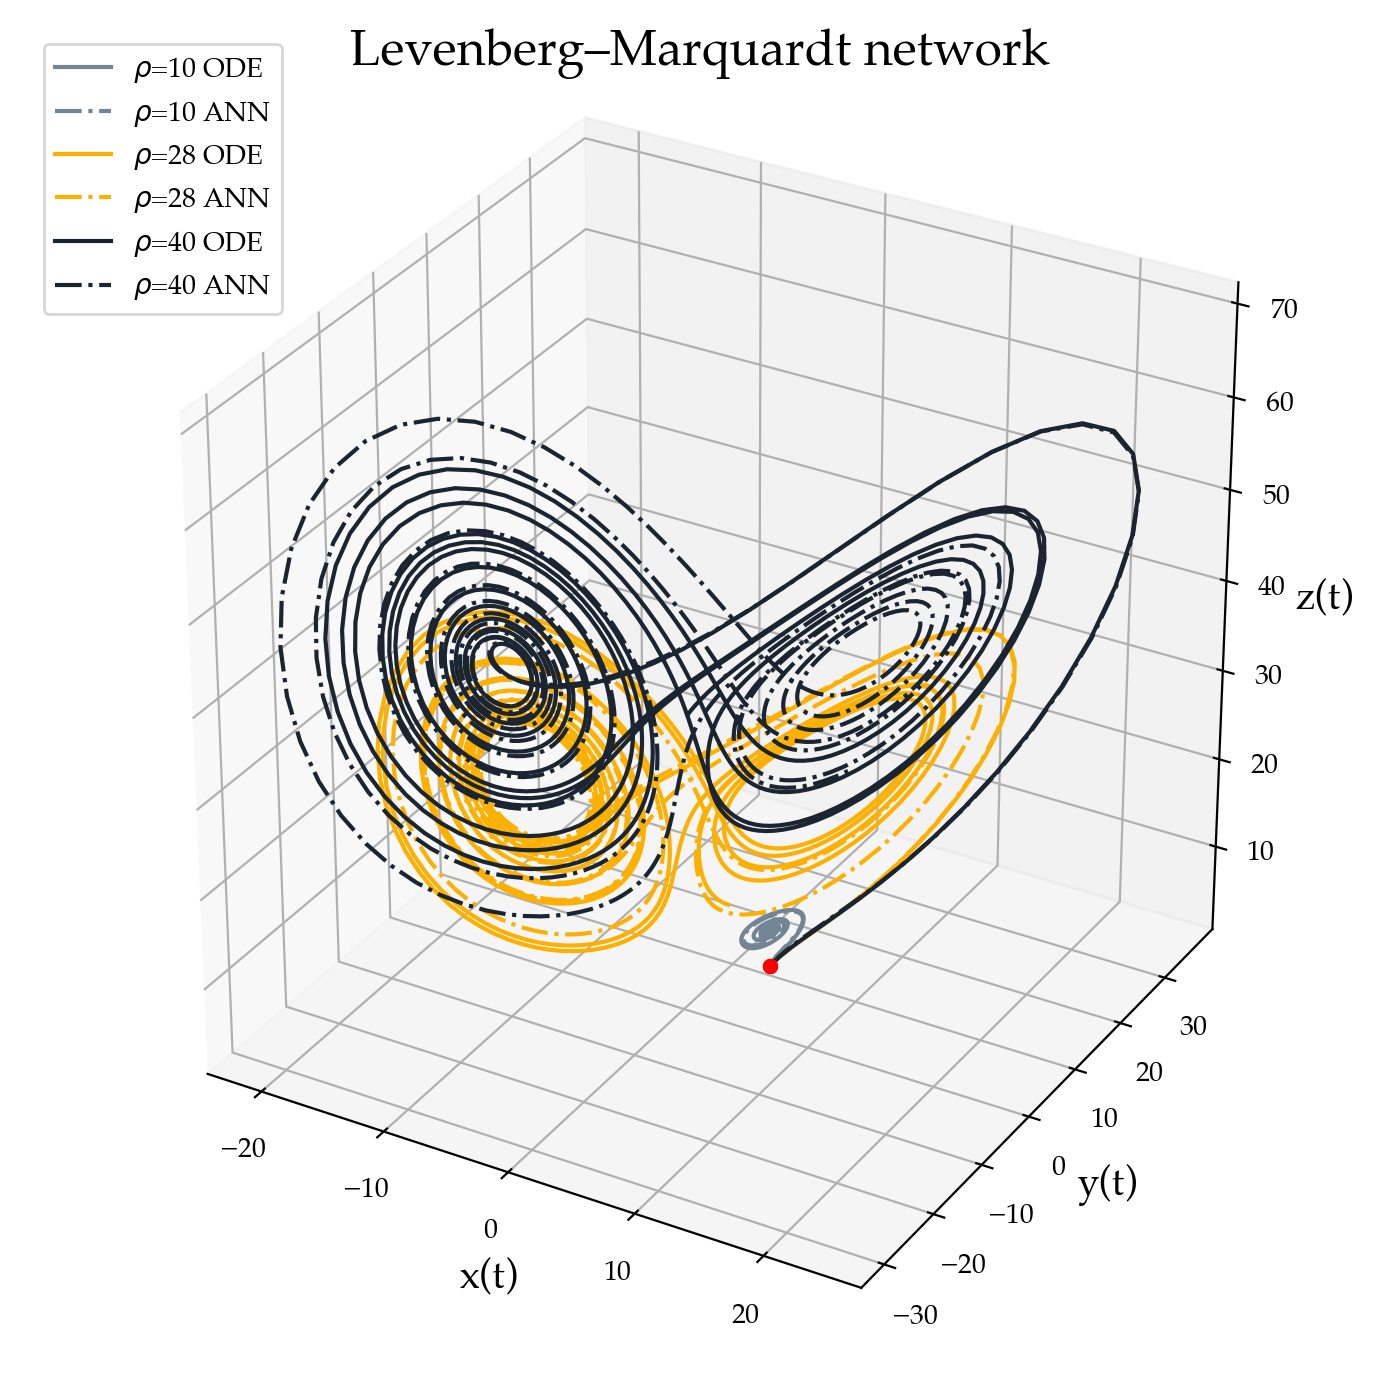

In [69]:
rho = [10, 28, 40]
lgd = []
colors = iter(['xkcd:steel', 'xkcd:yellow orange', 'xkcd:dark'])
x_hist_real = None
x_hist_LM = None

fig = plt.figure(figsize=(7, 7))
fig.suptitle("Levenberg–Marquardt network", fontsize=18)
gs = gridspec.GridSpec(1, 1)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.1, hspace=0.1)
ax = plt.subplot(gs[0, 0], projection='3d')
ax.set_xlabel('x(t)', fontsize = 14)
ax.set_ylabel('y(t)', fontsize = 14)
ax.set_zlabel('z(t)', fontsize = 14)

for _rho in rho:

    lor = odeint(Lorenz, x0, t, args=([], sigma, beta, _rho), mxstep=10**8) # integrate PDE
    x = np.reshape(lor[:, 0], (-1, 1))
    y = np.reshape(lor[:, 1], (-1, 1))
    z = np.reshape(lor[:, 2], (-1, 1))
    lgd.append(r'$\rho$=%d ODE' % _rho)

    ynn = np.zeros((len(t), 4))
    ynn[0, :-1] = x0
    ynn[:, -1] = _rho
    for i in range(len(t)-1):
        out = prn.NNOut(np.reshape(ynn[i, :], (4, 1)), net_LM)
        ynn[i+1, :-1] = np.reshape(out, (3,))
    lgd.append(r'$\rho$=%d ANN' % _rho)

    ax.scatter(x0[0], x0[1], x0[2], 'o', color='r')
    c = next(colors)
    ax.plot(x[:, 0], y[:, 0], z[:, 0], linewidth='1.5', color=c)
    ax.plot(ynn[:, 0], ynn[:, 1], ynn[:, 2], '-.', linewidth='1.5', color=c)
    
    x_hist_LM = ynn[None, :, 0] if x_hist_LM is None else np.vstack((x_hist_LM, ynn[None, :, 0]))
    x_hist_real = x.T if x_hist_real is None else np.vstack((x_hist_real, x.T)) 
    
ax.legend(lgd, fontsize = 10, loc='upper left')

gs.tight_layout(fig)

<IPython.core.display.Javascript object>


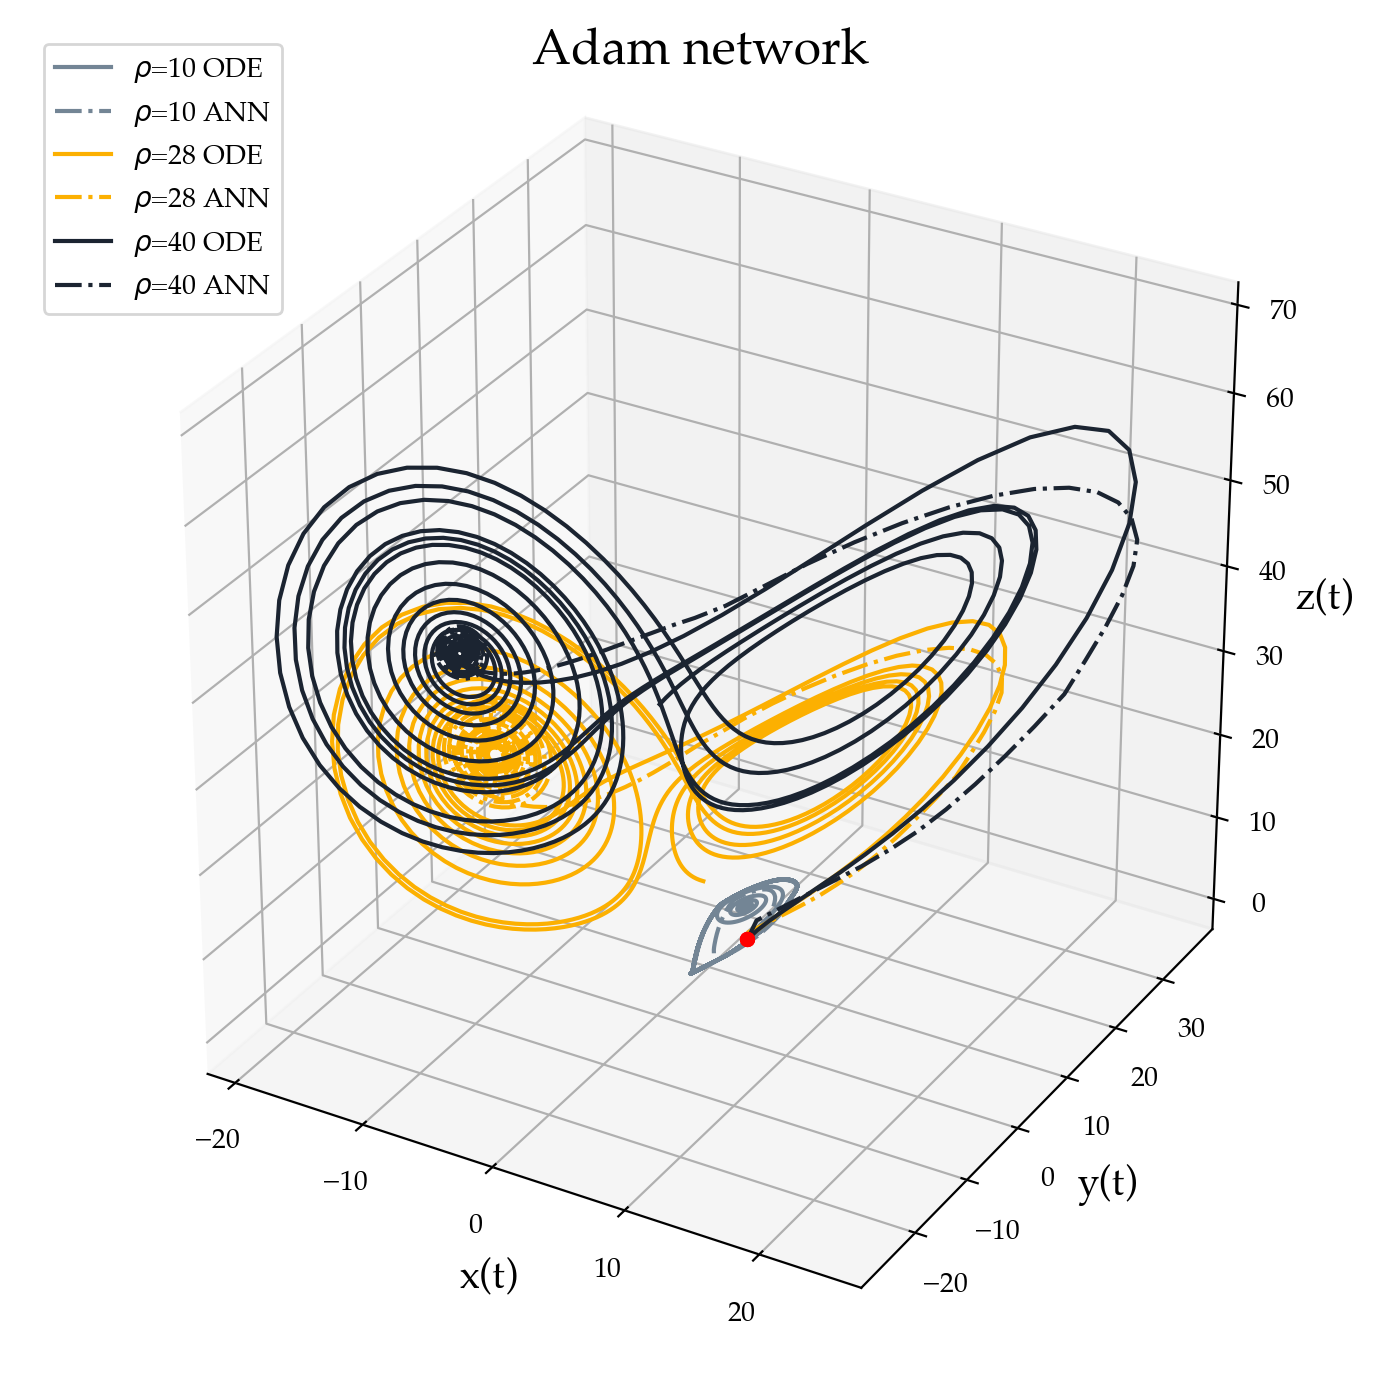

In [70]:
lgd = []
colors = iter(['xkcd:steel', 'xkcd:yellow orange', 'xkcd:dark'])
x_hist_A = None

fig = plt.figure(figsize=(7, 7))
fig.suptitle("Adam network", fontsize=18)
gs = gridspec.GridSpec(1, 1)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.1, hspace=0.1)
ax = plt.subplot(gs[0, 0], projection='3d')
ax.set_xlabel('x(t)', fontsize = 14)
ax.set_ylabel('y(t)', fontsize = 14)
ax.set_zlabel('z(t)', fontsize = 14)

count = 1
for _rho in rho:

    lor = odeint(Lorenz, x0, t, args=([], sigma, beta, _rho), mxstep=10**8) # integrate PDE
    x = np.reshape(lor[:, 0], (-1, 1))
    y = np.reshape(lor[:, 1], (-1, 1))
    z = np.reshape(lor[:, 2], (-1, 1))
    lgd.append(r'$\rho$=%d ODE' % _rho)

    ynn_A = np.zeros((len(t), 4))
    ynn_A[0, :-1] = x0
    ynn_A[:, -1] = _rho
    with torch.no_grad():
        for i in range(len(t)-1):
            ynn_A[i+1, :-1] = net_Adam(torch.from_numpy(ynn_A[i, :]).squeeze(0).float())
    lgd.append(r'$\rho$=%d ANN' % _rho)

    ax.scatter(x0[0], x0[1], x0[2], 'o', color='r')
    c = next(colors)
    ax.plot(x[:, 0], y[:, 0], z[:, 0], linewidth='1.5', color=c)
    ax.plot(ynn_A[:, 0], ynn_A[:, 1], ynn_A[:, 2], '-.', linewidth='1.5', color=c)
    
    x_hist_A = ynn_A[None, :, 0] if x_hist_A is None else np.vstack((x_hist_A, ynn_A[None, :, 0]))
    
ax.legend(lgd, fontsize = 10, loc='upper left')

gs.tight_layout(fig)

In [49]:
len(t), x_hist_real.shape, x_hist_LM.shape

(1001, (3, 1001), (3, 1001))

<IPython.core.display.Javascript object>


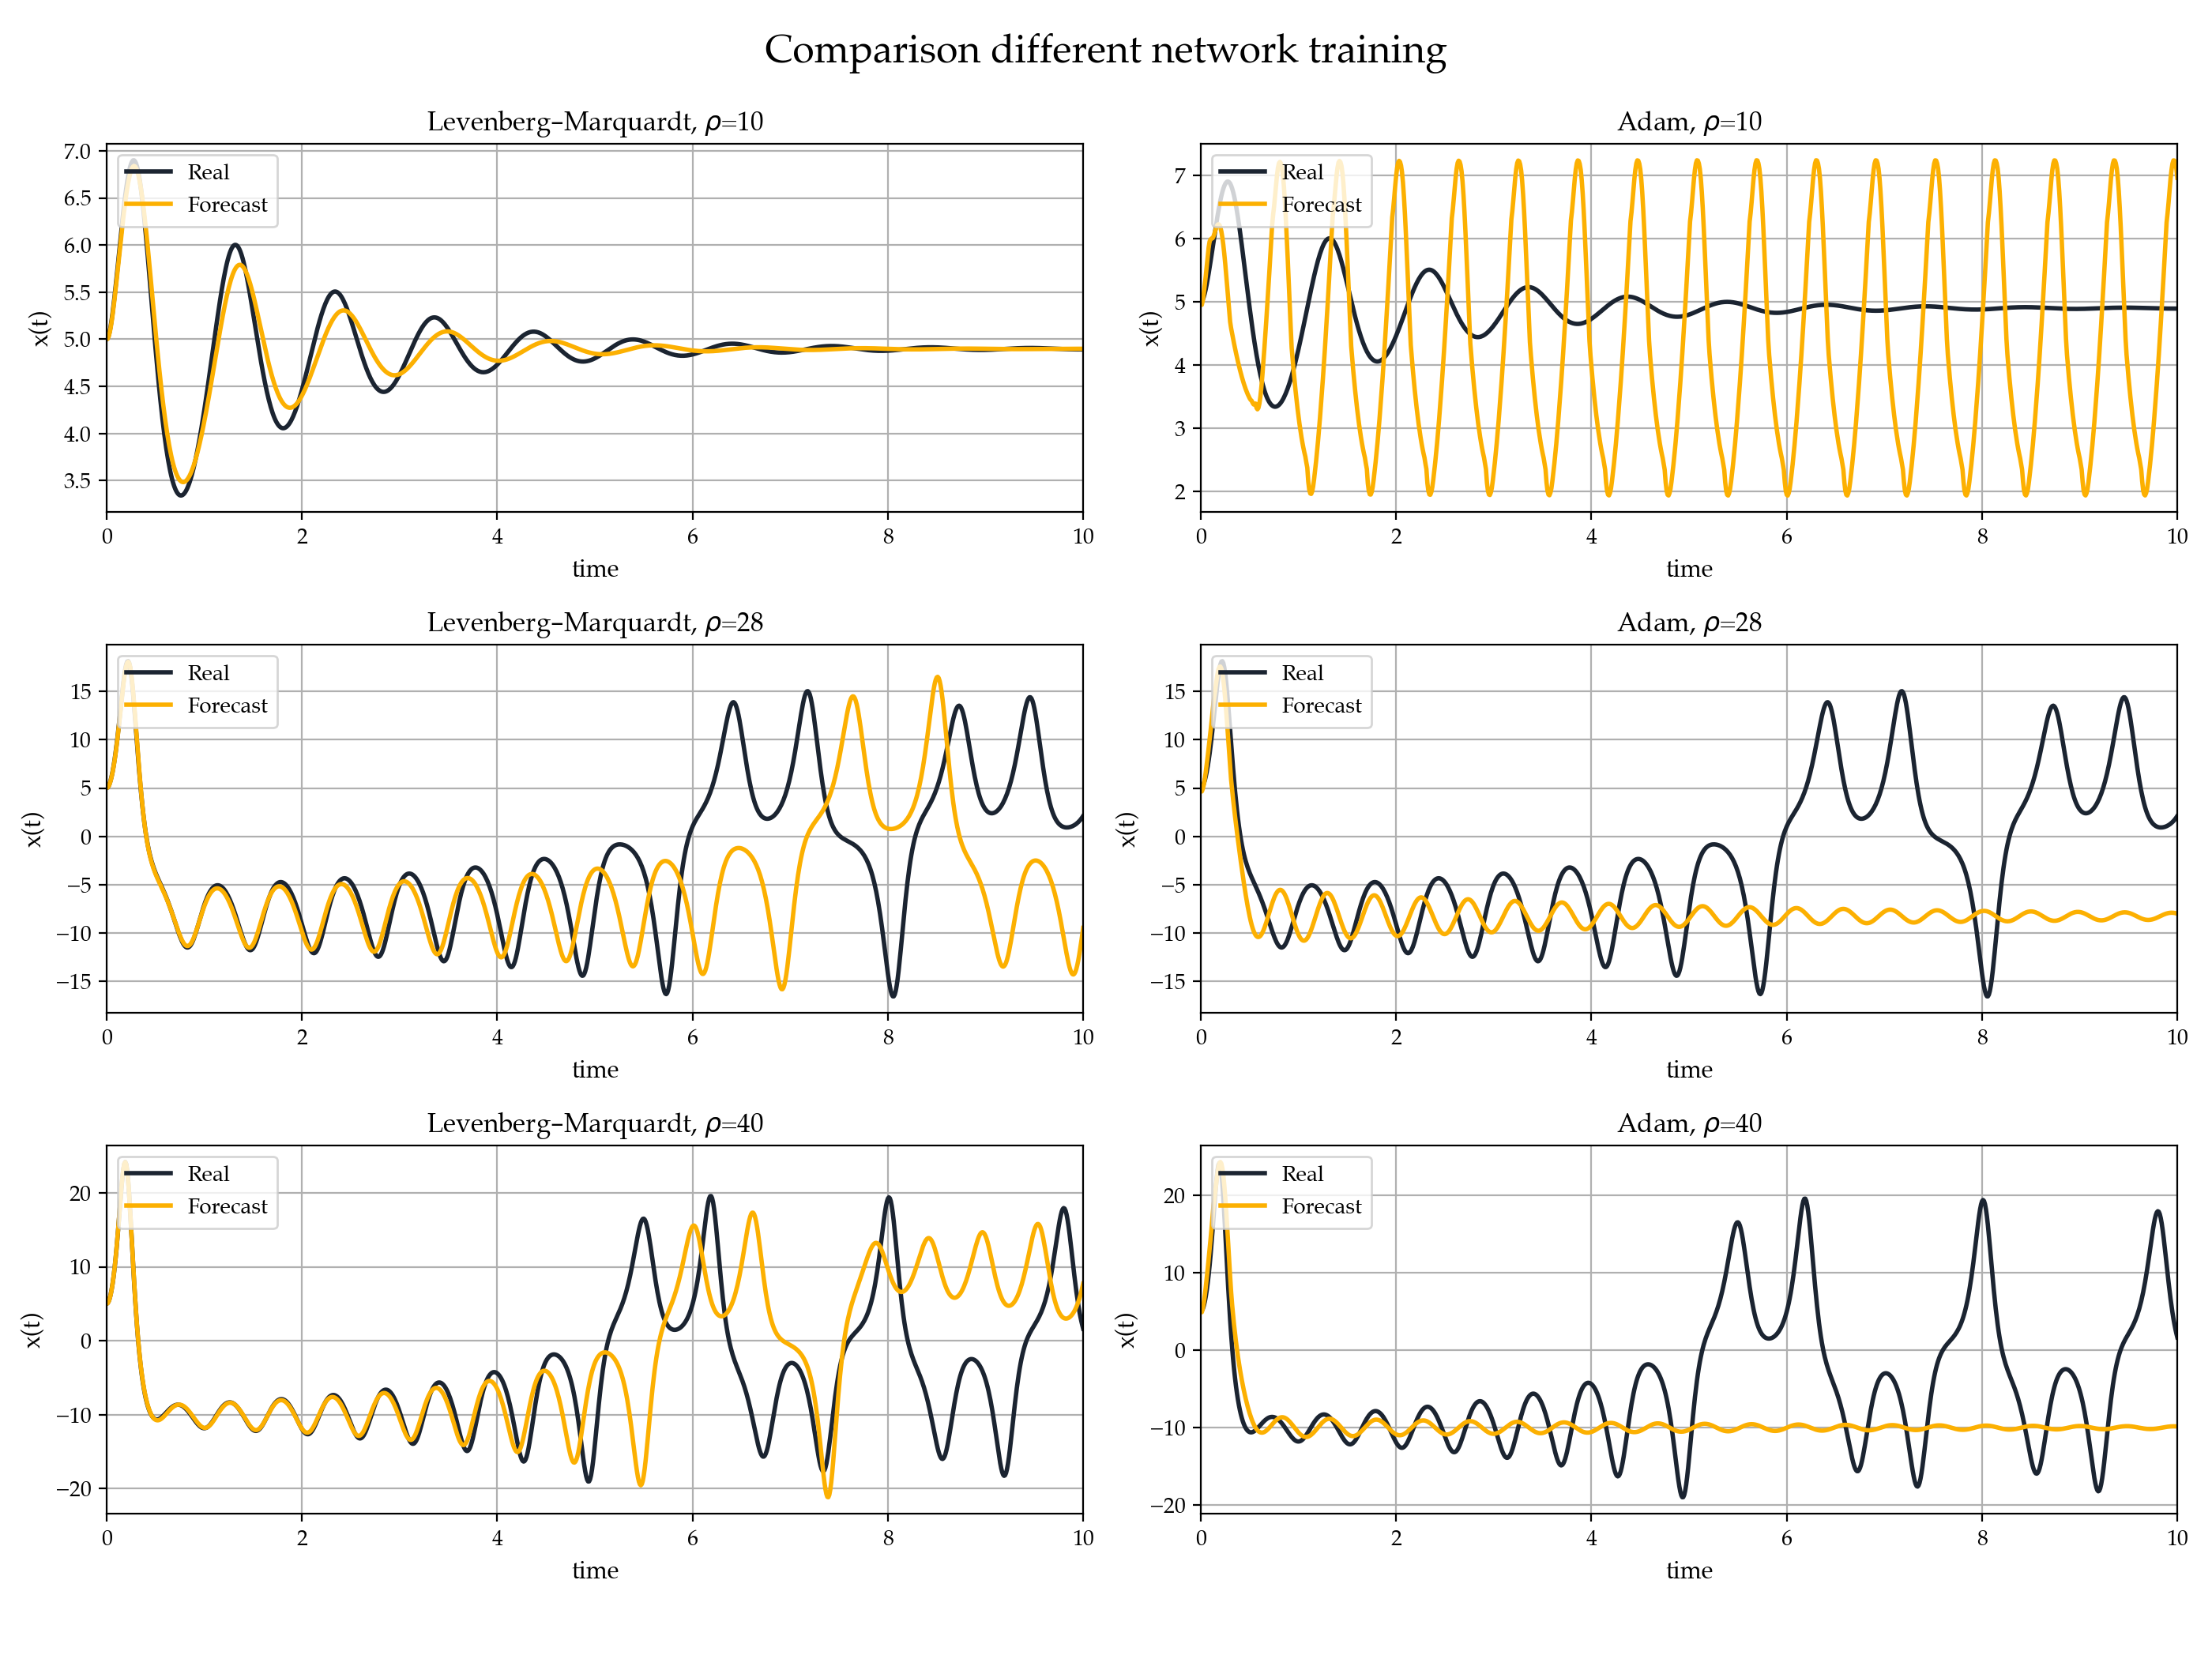

In [87]:
colors = ['xkcd:steel', 'xkcd:yellow orange', 'xkcd:dark']

fig = plt.figure(figsize=(14, 10.5))
fig.suptitle("Comparison different network training", fontsize=18)

gs = gridspec.GridSpec(3, 2)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

ax = plt.subplot(gs[0, 0])
h = ax.plot(t, x_hist_real[0, :], linewidth='2', color=colors[2])
h = ax.plot(t, x_hist_LM[0, :], linewidth='2', color=colors[1])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'Levenberg–Marquardt, $\rho$=10', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper left')
ax.grid()

ax = plt.subplot(gs[0, 1])
h = ax.plot(t, x_hist_real[0, :], linewidth='2', color=colors[2])
h = ax.plot(t, x_hist_A[0, :], linewidth='2', color=colors[1])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'Adam, $\rho$=10', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper left')
ax.grid()

ax = plt.subplot(gs[1, 0])
h = ax.plot(t, x_hist_real[1, :], linewidth='2', color=colors[2])
h = ax.plot(t, x_hist_LM[1, :], linewidth='2', color=colors[1])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'Levenberg–Marquardt, $\rho$=28', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper left')
ax.grid()

ax = plt.subplot(gs[1, 1])
h = ax.plot(t, x_hist_real[1, :], linewidth='2', color=colors[2])
h = ax.plot(t, x_hist_A[1, :], linewidth='2', color=colors[1])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'Adam, $\rho$=28', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper left')
ax.grid()

ax = plt.subplot(gs[2, 0])
h = ax.plot(t, x_hist_real[2, :], linewidth='2', color=colors[2])
h = ax.plot(t, x_hist_LM[2, :], linewidth='2', color=colors[1])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'Levenberg–Marquardt, $\rho$=40', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper left')
ax.grid()

ax = plt.subplot(gs[2, 1])
h = ax.plot(t, x_hist_real[2, :], linewidth='2', color=colors[2])
h = ax.plot(t, x_hist_A[2, :], linewidth='2', color=colors[1])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'Adam, $\rho$=40', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper left')
ax.grid()

gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])
#gs.tight_layout(fig)

fig.savefig('figures/comparison_train.pdf', format='pdf', dpi=1200)

<IPython.core.display.Javascript object>


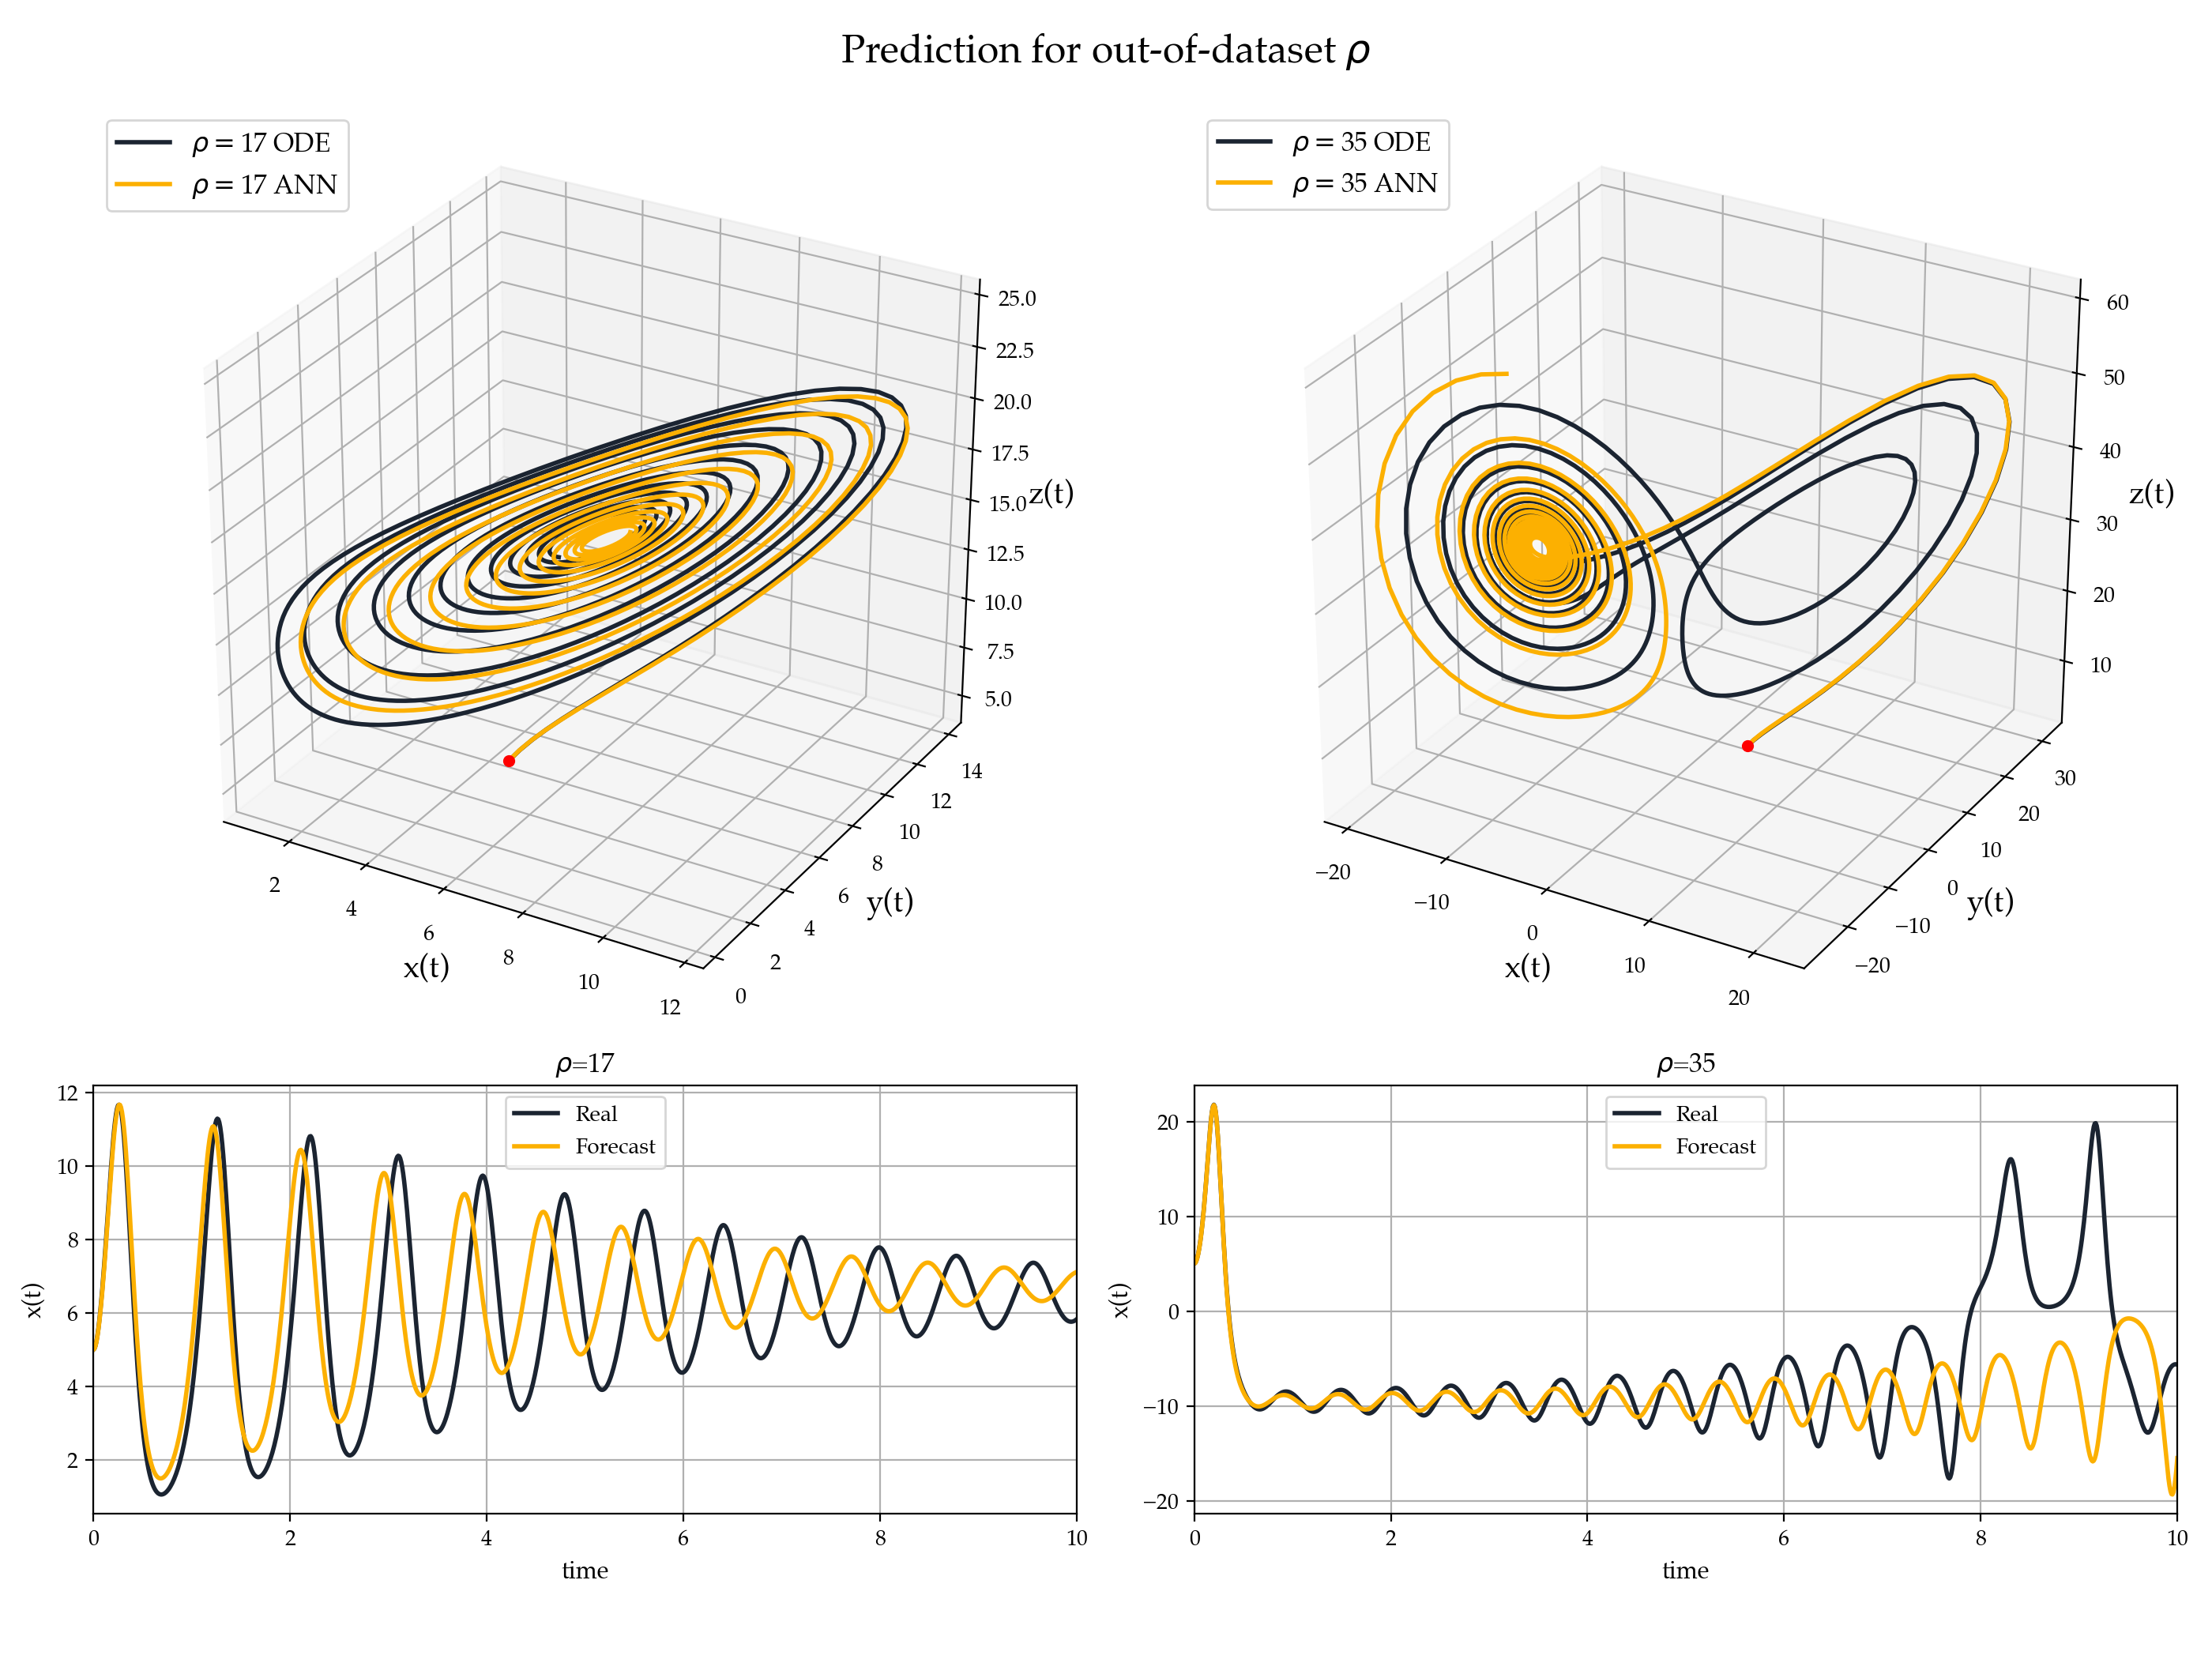

In [86]:
rho = [17, 35]
lgd = []
x_real = None
x_hist = None

colors = iter(['xkcd:yellow orange', 'xkcd:dark'])
_colors = ['xkcd:yellow orange', 'xkcd:dark']

fig = plt.figure(figsize=(14, 10.5))
fig.suptitle(r"Prediction for out-of-dataset $\rho$", fontsize=18)

gs = gridspec.GridSpec(3, 4)
gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)

# Rho = 17
_rho = rho[0]

ax = plt.subplot(gs[0:2, 0:2], projection='3d')
ax.set_xlabel('x(t)', fontsize = 14)
ax.set_ylabel('y(t)', fontsize = 14)
ax.set_zlabel('z(t)', fontsize = 14)

lor = odeint(Lorenz, x0, t, args=([], sigma, beta, _rho), mxstep=10**8) # integrate PDE
x = np.reshape(lor[:, 0], (-1, 1))
y = np.reshape(lor[:, 1], (-1, 1))
z = np.reshape(lor[:, 2], (-1, 1))
lgd.append(r'$\rho=$%d ODE' % _rho)

ynn = np.zeros((len(t), 4))
ynn[0, :-1] = x0
ynn[:, -1] = _rho
for i in range(len(t)-1):
    out = prn.NNOut(np.reshape(ynn[i, :], (4, 1)), net_LM)
    ynn[i+1, :-1] = np.reshape(out, (3,))
lgd.append(r'$\rho=$%d ANN' % _rho)

ax.scatter(x0[0], x0[1], x0[2], 'o', color='r')
c = next(colors)
ax.plot(x[:, 0], y[:, 0], z[:, 0], linewidth='2',color=_colors[1])
ax.plot(ynn[:, 0], ynn[:, 1], ynn[:, 2], linewidth='2', color=_colors[0])

x_hist = ynn[None, :, 0] if x_hist is None else np.vstack((x_hist, ynn[None, :, 0]))
x_real = x.T if x_real is None else np.vstack((x_real, x.T)) 
    
ax.legend(lgd, fontsize = 12, loc='upper left')

# Rho = 35
_rho = rho[1]
lgd = []

ax = plt.subplot(gs[0:2, 2:4], projection='3d')
ax.set_xlabel('x(t)', fontsize = 14)
ax.set_ylabel('y(t)', fontsize = 14)
ax.set_zlabel('z(t)', fontsize = 14)

lor = odeint(Lorenz, x0, t, args=([], sigma, beta, _rho), mxstep=10**8) # integrate PDE
x = np.reshape(lor[:, 0], (-1, 1))
y = np.reshape(lor[:, 1], (-1, 1))
z = np.reshape(lor[:, 2], (-1, 1))
lgd.append(r'$\rho=$%d ODE' % _rho)

ynn = np.zeros((len(t), 4))
ynn[0, :-1] = x0
ynn[:, -1] = _rho
for i in range(len(t)-1):
    out = prn.NNOut(np.reshape(ynn[i, :], (4, 1)), net_LM)
    ynn[i+1, :-1] = np.reshape(out, (3,))
lgd.append(r'$\rho=$%d ANN' % _rho)

ax.scatter(x0[0], x0[1], x0[2], 'o', color='r')
c = next(colors)
ax.plot(x[:, 0], y[:, 0], z[:, 0], linewidth='2', color=_colors[1])
ax.plot(ynn[:, 0], ynn[:, 1], ynn[:, 2], linewidth='2', color=_colors[0])

x_hist = ynn[None, :, 0] if x_hist is None else np.vstack((x_hist, ynn[None, :, 0]))
x_real = x.T if x_real is None else np.vstack((x_real, x.T)) 
    
ax.legend(lgd, fontsize = 12, loc='upper left')

ax = plt.subplot(gs[2, :2])
h = ax.plot(t, x_real[0, :], linewidth='2', color=_colors[1])
h = ax.plot(t, x_hist[0, :], linewidth='2', color=_colors[0])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'$\rho$=17', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper center')
ax.grid()

ax = plt.subplot(gs[2, 2:])
h = ax.plot(t, x_real[1, :], linewidth='2', color=_colors[1])
h = ax.plot(t, x_hist[1, :], linewidth='2', color=_colors[0])
ax.set_xlim([0, np.max(t)])
ax.set_title(r'$\rho$=35', fontsize = 12)
plt.xlabel('time', fontsize = 11)
plt.ylabel('x(t)', fontsize = 11)
plt.legend(['Real', 'Forecast'], fontsize = 10, loc='upper center')
ax.grid()


gs.tight_layout(fig, rect=[0, 0.03, 1, 0.95])

fig.savefig('figures/rho_oos.pdf', format='pdf', dpi=1200)